In [1]:
!pip install kaggle   # to get kaggle dataset

**Importing the Dependancies**






In [2]:
import os
import json                                                                     #these two are used for access the configration file

from zipfile import ZipFile                                                     #kaggle dataset comes in zip format so to unzip we use this ZipFile.
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer                       #To tokenize the text
from tensorflow.keras.preprocessing.sequence import pad_sequences               #to make sure text of same size

**Data collection using kaggle API**

To get the kaggle.json file:-
1. go to kaggle account
2. open setting and generate a token then you will get kaggle.json file
3. then upload or get the directory path to open this file

In [3]:
kaggle_dictonary = json.load(open("kaggle.json"))                               # open credentials of kaggle

In [4]:
#Setup kaggle credentials as envoirnment variable

os.environ["KAGGLE_USERNAME"] = kaggle_dictonary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictonary["key"]

In [5]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 97% 25.0M/25.7M [00:02<00:00, 21.4MB/s]
100% 25.7M/25.7M [00:02<00:00, 12.0MB/s]


In [6]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


In [7]:
# Unzip the dataset
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
  zip_ref.extractall()


In [8]:
!ls

'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   kaggle.json   sample_data


**Loading the dataset**

In [9]:
data = pd.read_csv("/content/IMDB Dataset.csv")

In [10]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [12]:
data["sentiment"].value_counts()  # Checking whether data is balanced or not

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [13]:
# Label encoding - sentiment column
data.replace({"sentiment": {"positive":1, "negative":0}}, inplace=True)

In [14]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [15]:
# Split data into train and test data

train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 23)

In [16]:
train_data.shape, test_data.shape

((40000, 2), (10000, 2))

**Data Preprocessing**

In [17]:
# Tokenizing text data
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen = 200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen = 200)

# text_to_sequences convert words to sequence of integer

In [18]:
print(X_train)

[[   0    0    0 ... 1167  636 2699]
 [  33   77   21 ...   49 2970   17]
 [   0    0    0 ...   77  225  416]
 ...
 [   0    0    0 ...   59  138  243]
 [   1   80  825 ...  338   10  165]
 [ 906 1382   37 ...    5    1 1110]]


In [19]:
print(X_test)

[[   0    0    0 ...  913    8    9]
 [  20  344   18 ...   25   76 2699]
 [   0    0    0 ...  180  206 2370]
 ...
 [   0    0    0 ...   11 1987   17]
 [  11   19  182 ...   57 1238 1045]
 [ 414   54  281 ...    1  654 2786]]


In [20]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [21]:
print(Y_train)

20198    0
34103    1
40179    1
34586    0
30725    0
        ..
9704     0
11190    1
26569    0
9256     1
41555    0
Name: sentiment, Length: 40000, dtype: int64


In [22]:
print(Y_test)

49466    1
11621    0
39058    1
10033    0
22076    0
        ..
16074    0
26432    1
17868    0
36795    0
39347    0
Name: sentiment, Length: 10000, dtype: int64


**Building the model using LSTM:-Long_short_term memory**

In [23]:
model = Sequential()
model.add(Embedding(input_dim = 5000, output_dim = 128, input_length = 200))    # embedding layer convert word to vector representation
model.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compile the model

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

**Training the model**

In [26]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 214s 419ms/step - loss: 0.4041 - accuracy: 0.8147 - val_loss: 0.3387 - val_accuracy: 0.8580
Epoch 2/5
500/500 [==============================] - 194s 388ms/step - loss: 0.2691 - accuracy: 0.8900 - val_loss: 0.3049 - val_accuracy: 0.8775
Epoch 3/5
500/500 [==============================] - 189s 378ms/step - loss: 0.2231 - accuracy: 0.9107 - val_loss: 0.3229 - val_accuracy: 0.8780
Epoch 4/5
500/500 [==============================] - 192s 384ms/step - loss: 0.1938 - accuracy: 0.9249 - val_loss: 0.3363 - val_accuracy: 0.8690
Epoch 5/5
500/500 [==============================] - 193s 386ms/step - loss: 0.1585 - accuracy: 0.9396 - val_loss: 0.3639 - val_accuracy: 0.8767


In [27]:
# Create a DataFrame from the training history
df_history = pd.DataFrame(history.history)

df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.404117,0.814687,0.338671,0.85800
1,0.269092,0.890031,0.304874,0.87750
2,0.223092,0.910656,0.322916,0.87800
3,0.193777,0.924937,0.336310,0.86900
4,0.158452,0.939562,0.363913,0.87675


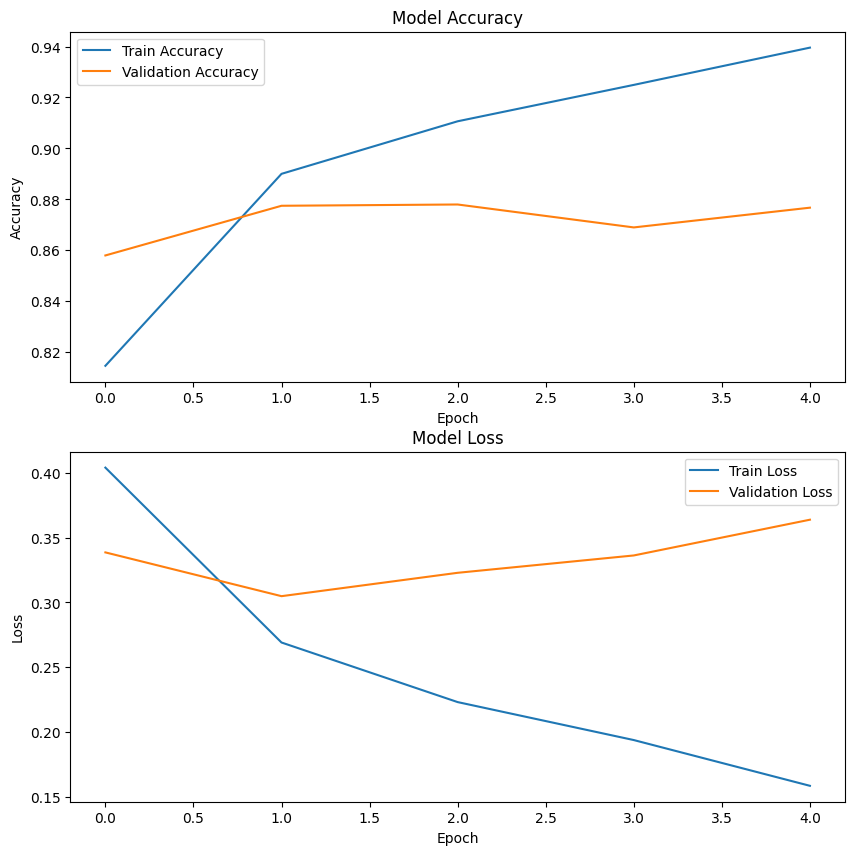

In [28]:
# prompt: generate code to plot model performace using above code

import matplotlib.pyplot as plt

# Get the training and validation accuracy from the history dictionary.
train_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# Get the training and validation loss from the history dictionary.
train_loss = df_history['loss']
val_loss = df_history['val_loss']

# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the training and validation accuracy on the first subplot.
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot the training and validation loss on the second subplot.
ax2.plot(train_loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plot.
plt.show()


**Model Evaluation**

In [29]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test_Loss {loss}")
print(f"Test_Accuracy = {accuracy}")

313/313 [==============================] - 19s 58ms/step - loss: 0.3477 - accuracy: 0.8856
Test_Loss 0.3476532995700836
Test_Accuracy = 0.8855999708175659


**Build a predictive system**

In [32]:
def predict_sentiment(review):
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen = 200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment


In [33]:
new_review = "This movie was fantastic, must watch."
sentiment = predict_sentiment(new_review)
print("The sentment for the review is:-", sentiment)

1/1 [==============================] - 0s 474ms/step
The sentment for the review is:- positive


In [34]:
new_review = "This movie was too bad,don't waste your money."
sentiment = predict_sentiment(new_review)
print("The sentment for the review is:-", sentiment)

1/1 [==============================] - 0s 66ms/step
The sentment for the review is:- negative


In [37]:
!pip install gradio

In [40]:
# prompt: Genereate  gradio for above code

import gradio as gr

def predict_sentiment(review):
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen = 200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(),
    outputs="text",
)

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a10d0884d0395604fd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
